### Required packages

In [14]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yfin
from tqdm import tqdm

import logging
logger = logging.getLogger('yfinance')
logger.disabled = True
logger.propagate = False

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


yfin.pdr_override()

# Financial Time Series Filtration using Random Matrix Theory Methods

## Introduction

This notebook explores the application of Random Matrix Theory (RMT) methods to the filtration of financial time series data. Financial markets generate vast amounts of data that are often noisy and complex. Filtering this data to extract meaningful information is crucial for effective analysis and decision-making.

### The Importance of Financial Time Series Analysis

Financial time series analysis involves understanding market behaviors, identifying trends, and forecasting future movements. It is fundamental for risk management, portfolio optimization, and strategic investment planning.

### Introduction to Random Matrix Theory (RMT)

Random Matrix Theory, initially developed in physics, has found applications in various fields, including finance. It provides a framework for analyzing the properties of matrices that have random components. In financial time series analysis, RMT helps in distinguishing genuine correlations in asset price movements from those arising due to noise.

In this notebook, we will apply RMT methods, particularly focusing on the Marchenko-Pastur law, to analyze financial time series data. The goal is to demonstrate how these advanced mathematical tools can enhance our understanding and filtering of financial data.


## RMT and the Marchenko-Pastur Law
### The Marchenko-Pastur Law

The Marchenko-Pastur law provides a probability distribution of eigenvalues for random matrices under certain conditions. This distribution is pivotal in RMT, enabling analysts to differentiate between random noise and significant eigenvalues in financial data correlation matrices.

### Application to Financial Data

Applying the Marchenko-Pastur law involves calculating the eigenvalues of the correlation matrix derived from financial time series data. By comparing these eigenvalues against the theoretical distribution, we can identify which correlations are likely to be meaningful.


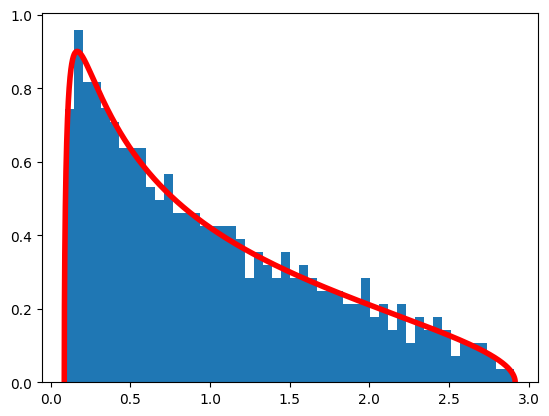

In [15]:
# Definition of the Marchenko-Pastur density
def marchenko_pastur_pdf(x,Q,sigma=1):
    y=1/Q
    b=np.power(sigma*(1 + np.sqrt(1/Q)),2) # Largest eigenvalue
    a=np.power(sigma*(1 - np.sqrt(1/Q)),2) # Smallest eigenvalue
    return (1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))*(0 if (x > b or x <a ) else 1)

def compare_eigenvalue_distribution(correlation_matrix, Q, sigma=1, set_autoscale = True, show_top = True):
    e, _ = np.linalg.eig(correlation_matrix) # Correlation matrix is Hermitian, so this is faster than other variants of eig

    x_min = .0001 if np.power(sigma*(1 - np.sqrt(1/Q)),2) < .0001 else np.power(sigma*(1 - np.sqrt(1/Q)),2)
    x_max = np.power(sigma*(1 + np.sqrt(1/Q)),2)

    fig = plt.figure()
    ax  = fig.add_subplot(111)
    bins = 50
    if not show_top:
        # Clear top eigenvalue from plot
        e=e[ e <= x_max+1]
    ax.hist(e, density=True, bins=50) # Histogram the eigenvalues
    ax.set_autoscale_on(set_autoscale)

    # Plot the theoretical density
    f = np.vectorize(lambda x : marchenko_pastur_pdf(x,Q,sigma=sigma))

    x_min = .0001 if np.power(sigma*(1 - np.sqrt(1/Q)),2) < .0001 else np.power(sigma*(1 - np.sqrt(1/Q)),2)
    x_max = np.power(sigma*(1 + np.sqrt(1/Q)),2)

    x = np.linspace(x_min,x_max,5000)
    ax.plot(x,f(x), linewidth=4, color = 'r')

# Create the correlation matrix and find the eigenvalues
N= 500
T= 1000
X= np.random.normal(0,1,size=(N,T))
cor = np.corrcoef(X)
Q= T/N
compare_eigenvalue_distribution(cor, Q)

### Data Preparation Steps

We start by fetching financial data for selected tickers over a specified period. The initial steps involve:
1. Setting up the time range for our analysis.
2. Retrieving stock prices and calculating daily returns.
3. Cleaning the data by removing any infinite or missing values to ensure the quality and consistency of our dataset.

This preparation is critical for the accurate application of Random Matrix Theory methods in the subsequent analysis.

In [16]:
np.random.seed(6)

start, end = dt.datetime(2019, 1, 1), dt.datetime(2020, 12, 31)

tickers = pd.read_csv('https://raw.githubusercontent.com/ae-bii/correlation-filtering-using-rmt/master/nasdaq_tickers.csv', header=None)[0]
tickers = np.random.choice(tickers.values, size=75, replace=False) # Choose a random set of headers
prices = pd.DataFrame()
for ticker in tqdm(tickers):
    try:
        prices[ticker] = pdr.get_data_yahoo(ticker, start, end, progress=False).loc[:,'Close']
    except Exception as e:
        pass
returns = prices.pct_change()
returns = returns.iloc[1:, :]# Remove first row of NA's generated by pct_changes()
returns.dropna(axis = 1, thresh=len(returns.index)/2, inplace=True) # Drop stocks with over half the data missing
returns.dropna(axis = 0, thresh=len(returns.columns), inplace=True) # Drop days without data for all stocks
training_period = int(returns.shape[0]/2)
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()
tickers = in_sample.columns

returns.shape

100%|██████████| 75/75 [00:14<00:00,  5.16it/s]
/run/user/1000/ipykernel_87434/3560943736.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change()


(302, 54)

In [17]:
log_in_sample = in_sample.apply(lambda x : np.log(x+1))
log_in_sample.dropna(axis=0, inplace= True)
log_in_sample.dropna(axis=1, inplace = True)

variances = np.diag(log_in_sample.cov().values)
standard_deviations = np.sqrt(variances)

## Data Analysis Using RMT

This section delves into the practical application of Random Matrix Theory on our financial time series dataset. The steps include:

1. **Eigenvalue Calculation**: We compute the eigenvalues of the correlation matrix obtained from the financial time series data.
2. **Applying the Marchenko-Pastur Law**: By comparing the calculated eigenvalues with those expected under the Marchenko-Pastur law, we identify which parts of the spectrum represent signal and which represent noise.
3. **Interpretation of Results**: Analyzing the spectrum of eigenvalues aids in understanding the structure of correlations in financial markets, offering insights into market dynamics and potential risks.

Through this analysis, RMT assists in filtering out noise, focusing on the underlying structures in financial data.


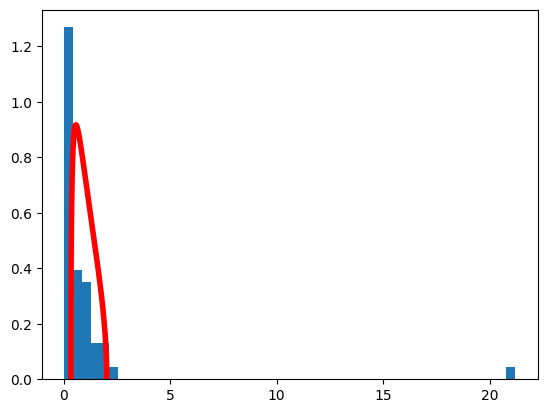

In [18]:
T, N = returns.shape
Q=T/N

correlation_matrix = log_in_sample.interpolate().corr()
correlation_matrix.replace([np.nan], 0, inplace=True)

compare_eigenvalue_distribution(correlation_matrix, Q, set_autoscale = True)

The largest eigenvalue (called the market eigenvalue) and its corresponding eigenportfolio often show a strong correlation with the overall market, provided that the matrix is constructed using data reflective of the market dynamics. In practical applications of this method, it is common to exclude this particular eigenportfolio to achieve returns that are, ideally, independent of market movements.

In [19]:
 # Let's see the eigenvalues larger than the largest theoretical eigenvalue
sigma = 1 # The variance for all of the standardized log returns is 1
max_theoretical_eval = np.power(sigma*(1 + np.sqrt(1/Q)),2)
min_theoretical_eval = np.power(sigma*(1 - np.sqrt(1/Q)),2)

D, S = np.linalg.eigh(correlation_matrix)

print(D[D > max_theoretical_eval])
print(D[D < min_theoretical_eval])

[ 2.11216086  2.43821091 21.20106449]
[0.0278189  0.04296514 0.04874754 0.05770096 0.06683487 0.06983203
 0.08018417 0.09239763 0.09480726 0.10484384 0.11933281 0.12163524
 0.1463851  0.15735356 0.16710495 0.19004435 0.21131614 0.21618499
 0.22885048 0.23681042 0.27185249 0.2829806  0.30219105 0.32391162]


Given that this Marchenko-Pastur Law characterizes the range of eigenvalues for random matrices, eigenvalues from correlation matrices landing within this specified range can be interpreted as either noise or irrelevant data.

Also, each eigenvalue reflects a certain level of variance within a portfolio, so when an eigenvalue is low, it suggests a combination of portfolio exists that can generate returns with minimal risk. However, this idea is generally seen as unrealistic and is often chalked up to errors in data sampling.

<Axes: title={'center': 'Filtered'}>

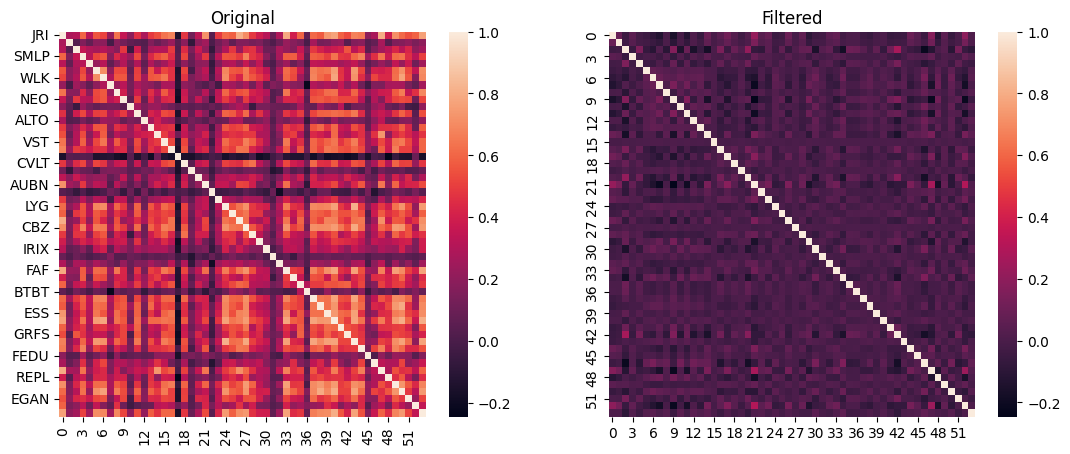

In [20]:
 # Filter the eigenvalues out
D[D <= max_theoretical_eval] = 0
D[D == np.max(D)] = 0

# Reconstruct the matrix
temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))

# Set the diagonal entries to 0
np.fill_diagonal(temp, 1)
filtered_matrix = temp


f, axes = plt.subplots(1, 2, sharex=True, figsize=(13, 5))
axes[0].set_title("Original")
sns.heatmap(correlation_matrix, ax=axes[0])
axes[1].set_title("Filtered")
sns.heatmap(filtered_matrix, ax=axes[1])

### Clustered Correlation Matrix

In [21]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

<Axes: title={'center': 'Filtered'}>

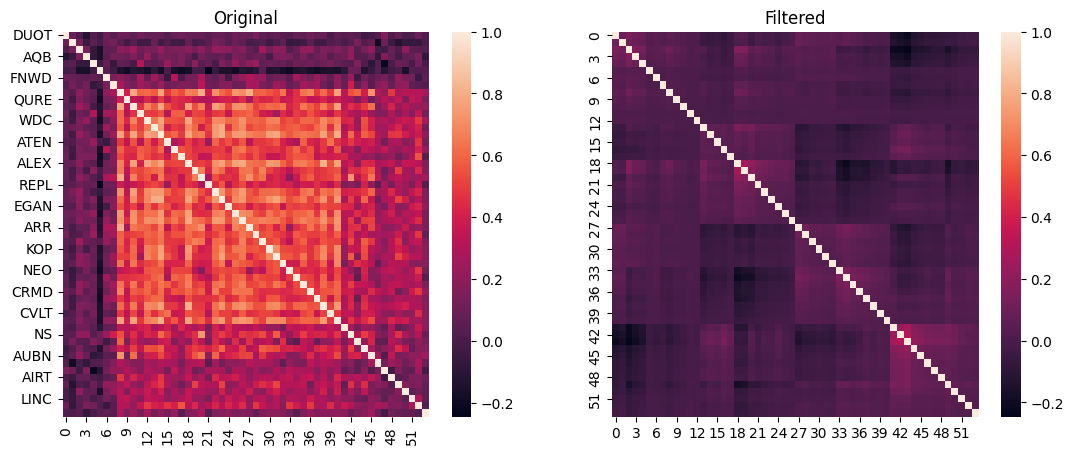

In [22]:
f, axes = plt.subplots(1, 2, sharex=True, figsize=(13, 5))
axes[0].set_title("Original")
sns.heatmap(cluster_corr(correlation_matrix), ax=axes[0])
axes[1].set_title("Filtered")
sns.heatmap(cluster_corr(filtered_matrix), ax=axes[1])

## Minimum Variance Portfolio Construction

### Understanding Portfolio Variance

In portfolio theory, variance is a measure of risk that represents the dispersion of returns of a portfolio. Managing this variance is crucial for investors seeking to optimize their risk-reward ratio. The concept of the minimum variance portfolio (MVP) arises from the desire to minimize risk for a given level of expected return.

### The Concept of the Minimum Variance Portfolio

The Minimum Variance Portfolio is the portfolio that has the lowest possible variance among all portfolios of risky assets. It is a key concept in modern portfolio theory, highlighting the importance of diversification. By carefully selecting assets that are not perfectly correlated, investors can reduce the overall variance of the portfolio, thus minimizing risk.

### Mathematical Formulation

The construction of the minimum variance portfolio involves solving an optimization problem where the objective is to minimize the portfolio's variance subject to certain constraints (e.g., the sum of the weights equals one, and the portfolio weights are non-negative for long-only portfolios). Mathematically, this can be represented as:

$$
\min_{\mathbf{w}} \left( \mathbf{w}^\top \Sigma \mathbf{w} \right)
$$

subject to:

$$\sum_{i} w_i = 1$$

where:
- $\mathbf{w}$ is the vector of portfolio weights,
- $\Sigma$ is the covariance matrix of asset returns.

If you are interested in futher reading, see [Determining the Global Minimum Variance Portfolio Using Matrix Algebra](https://bookdown.org/compfinezbook/introcompfinr/Determining-the-Global.html).

### Application to Financial Data

Applying the minimum variance portfolio construction in the context of financial time series involves:
1. Calculating the covariance matrix of asset returns based on historical data.
2. Solving the optimization problem to find the portfolio weights that minimize variance.

This process requires careful data preparation and analysis, as the effectiveness of the minimum variance portfolio depends on the accuracy and stability of the estimated covariance matrix.

### Significance in Portfolio Management

The minimum variance portfolio plays a pivotal role in portfolio management and asset allocation. It provides a benchmark for risk minimization and is often used as a starting point for constructing portfolios that aim to achieve the best possible trade-off between risk and return.


      Investment Weight
FNWD           0.476081
GRFS           0.143949
BMY            0.124304
WIT            0.116829
FAF            0.089945
      Investment Weight
FNWD           0.189212
BMY            0.071189
WIT            0.050659
NFLX           0.043381
LII            0.037291


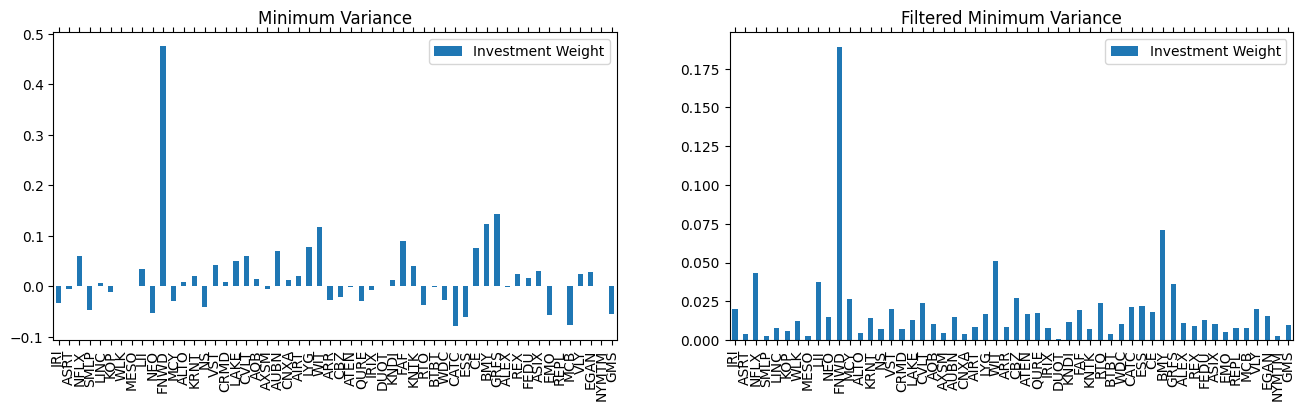

In [23]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(16,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights,
                                    columns = ['Investment Weight'],
                                    index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

print(min_var_portfolio.sort_values('Investment Weight', ascending=False).head())

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations),
                            np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights,
                                    columns = ['Investment Weight'],
                                    index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values('Investment Weight', ascending=False).head())


[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Filtered (Blue) vs. Normal (Black) vs. S&P500 (Green)')

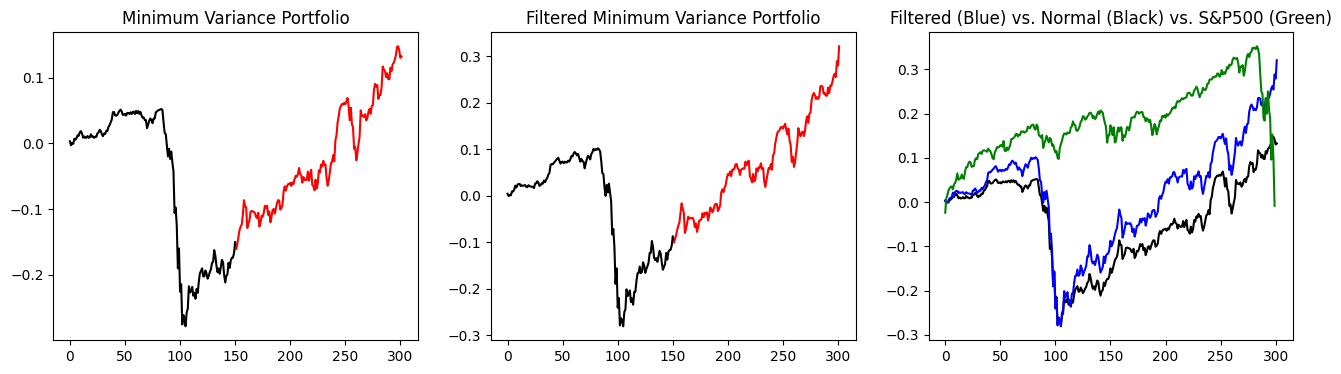

In [24]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values


sp500 = pdr.get_data_yahoo('SPY', start, end).loc[:,'Close']

returns_sp500 = sp500.pct_change()
returns_sp500 = returns_sp500.iloc[1:]# Remove first row of NA's generated by pct_changes()


cumulative_returns_sp500 = (((1+returns_sp500).cumprod(axis=0))-1).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'b')
ax.plot(cumulative_returns_sp500[:300], 'g')
plt.title("Filtered (Blue) vs. Normal (Black) vs. S&P500 (Green)")

## Results and Conclusion

### Summary of Key Findings

Our application of Random Matrix Theory to financial time series data reveals:
- The presence of eigenvalues outside the bounds predicted by the Marchenko-Pastur law, indicating genuine correlations among asset returns.
- Insights into the market's structure and dynamics, highlighting potential areas for further investigation or investment.

### Implications for Financial Modeling

The findings underscore the importance of distinguishing between noise and significant information in financial data. This distinction enhances risk management strategies and portfolio optimization, contributing to more informed decision-making processes.

### Further Research Directions

Future exploration could focus on extending RMT analysis to different markets or asset classes, investigating the stability of correlations over time, or integrating RMT with other statistical or machine learning methods for comprehensive market analysis.
